# Circos plot of cancer genomics 

This notebook follows closely to [this online tutorial](https://training.galaxyproject.org/training-material/topics/visualisation/tutorials/circos/tutorial.html#example-cancer-genomics).  The datasets are available [here](https://zenodo.org/record/4494146/#.Y0cinnbMIQg) and should be downloaded into the ```data``` directory (which you may have to create).

We will use the [pyCircos](https://github.com/ponnhide/pyCircos) package in Python. Unfortunately, the documentation for this package is a bit sparse.  However, there are good example notebooks at the bottom of their GitHub repo (linked above).

*Note:* this Jupyter notebook was converted to an html file using the following command in a terminal :

```
jupyter nbconvert --execute --to html circos.ipynb
```
___
*Author : Aaron M Geller, Dec. 2022*

In [1]:
# Run this cell to create the data directory and download the sample data.
# On subsequent runs of this notebook, you can skip this step
# Note: the first two files here are large (~40MB each). So, this cell may take a while to run.
# If they don't download properly here, you can simply download them manually from the 
#   zenodo website: https://zenodo.org/record/4494146/

import urllib
import os

# set this value to TRUE in order to download the data
getData = False
if (getData):
    directory = os.path.join(os.getcwd(), 'data')
    if (not os.path.exists(directory)):
        os.mkdir(directory)
    _ = urllib.request.urlretrieve('https://zenodo.org/record/4494146/files/VCaP_Copy-Number.tsv?download=1', 
                                   os.path.join(directory, 'VCaP_Copy-Number.tsv'))
    _ = urllib.request.urlretrieve('https://zenodo.org/record/4494146/files/VCaP_B-allele-Frequency.tsv?download=1', 
                                   os.path.join(directory, 'VCaP_B-allele-Frequency.tsv'))
    _ = urllib.request.urlretrieve('https://zenodo.org/record/4494146/files/VCaP-highConfidenceJunctions.tsv?download=1', 
                                   os.path.join(directory, 'VCaP-highConfidenceJunctions.tsv'))
    _ = urllib.request.urlretrieve('https://zenodo.org/record/4494146/files/hg18_karyotype_withbands.txt?download=1', 
                                   os.path.join(directory, 'hg18_karyotype_withbands.txt'))
    _ = urllib.request.urlretrieve('https://zenodo.org/record/4494146/files/chrome.tab?download=1', 
                                   os.path.join(directory, 'chrome.tab'))

In [2]:
# import necessary libraries
import pandas as pd
import pycircos

## 1. Create the Ideogram

### 1.1. Read in the Karyotype Configuration data using [```pandas```](https://pandas.pydata.org/).

In [3]:
# this file contains the general sizes for the chromosomes
dfChromInit = pd.read_csv('data/chrom.tab', sep = "\s+", header = None,
                         names = ['_0','_1','_2','chromosomeID','chromStart','chromEnd','chromosome'])
# fix a naming inconsistency
dfChromInit.replace('chrx','chrX', inplace = True)
dfChromInit.replace('chry','chrY', inplace = True)

# create a list of names for use later
names = dfChromInit['chromosome'].values

dfChromInit.head()

,_0,_1,_2,chromosomeID,chromStart,chromEnd,chromosome
0,chr,-,hs1,1,0,249250621,chr1
1,chr,-,hs2,2,0,243199373,chr2
2,chr,-,hs3,3,0,198022430,chr3
3,chr,-,hs4,4,0,191154276,chr4
4,chr,-,hs5,5,0,180915260,chr5


In [4]:
# read in the data and define the columns
# skip extra rows at the top that are not useful here
dfChrom = pd.read_csv('data/hg18_karyotype_withbands.txt', sep = "\s+" , header = None, skiprows = 24, 
                      names = ['_0','chromosome','band','_1','chromStart','chromEnd','Stain'])

# group the dataframe by the chromosome name so that it is easier to work with later
dfChrom = dfChrom.groupby('chromosome')

dfChrom.get_group('chr1')

,_0,chromosome,band,_1,chromStart,chromEnd,Stain
0,band,chr1,p36.33,p36.33,0,2300000,gneg
1,band,chr1,p36.32,p36.32,2300000,5300000,gpos25
2,band,chr1,p36.31,p36.31,5300000,7100000,gneg
3,band,chr1,p36.23,p36.23,7100000,9200000,gpos25
4,band,chr1,p36.22,p36.22,9200000,12600000,gneg
...,...,...,...,...,...,...,...
58,band,chr1,q42.13,q42.13,225100000,228800000,gneg
59,band,chr1,q42.2,q42.2,228800000,232700000,gpos50
60,band,chr1,q42.3,q42.3,232700000,234600000,gneg
61,band,chr1,q43,q43,234600000,241700000,gpos75


### 1.2. Create the initial circos figure showing the Ideogram.

In [5]:
# this object will hold our circos figure
circle = pycircos.Gcircle()

<Figure size 800x800 with 0 Axes>

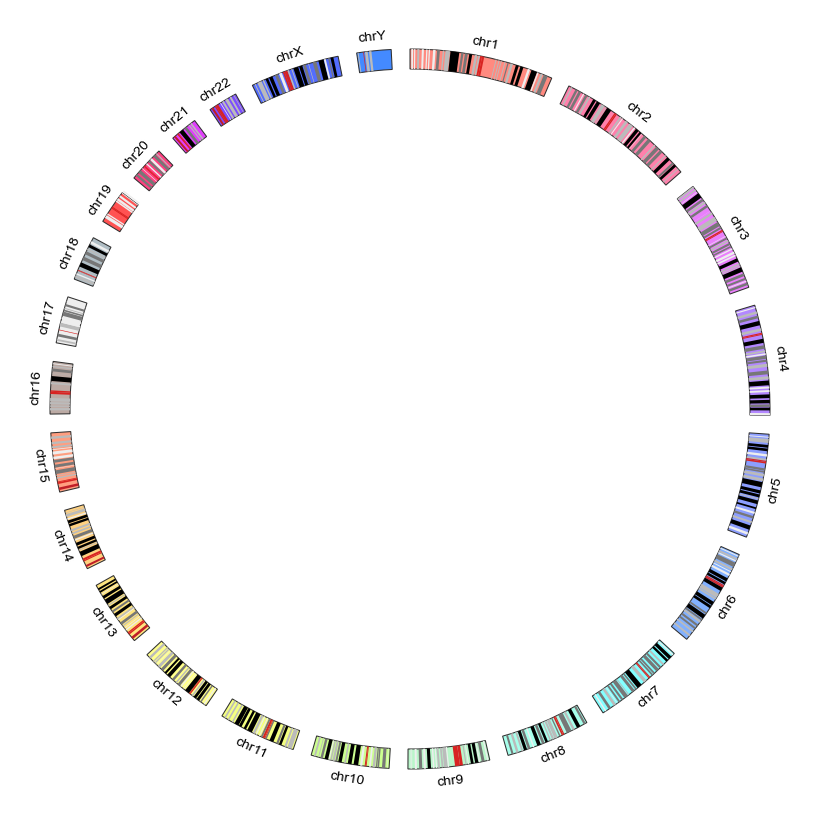

In [6]:
# define colors to use for each type of stain
color_dict   = {"gneg":"#FFFFFF00", "gpos25":"#EEEEEE", "gpos50":"#BBBBBB", "gpos75":"#777777", "gpos100":"#000000", 
                "gvar":"#FFFFFF00", "stalk":"#C01E27", "acen":"#D82322"}

# create the boxes for the ideogram
for index, row in dfChromInit.iterrows():
    # create the band
    name = row['chromosome']
    arc = pycircos.Garc(
        arc_id = name, 
        size = row['chromEnd'], 
        interspace = 3, 
        raxis_range = (850, 900), 
        labelposition = 60, 
        label_visible = True
    )
    circle.add_garc(arc) 
    
# set the bands
circle.set_garcs() 


# add the lines in each band (as a barplot with each band having a height of 1)
for name in names:
    usedf = dfChrom.get_group(name)
    circle.barplot(
        name, 
        data = [1]*len(usedf), 
        positions = usedf['chromStart'].values, 
        width = (usedf['chromEnd'] - usedf['chromStart']).values, 
        raxis_range = [850, 900], 
        facecolor = usedf['Stain'].map(color_dict).values
    )  


# show the figure
circle.figure

## 2. Create a scatter plot of the Copy Number Variation data

### 2.1. Read in the Copy Number Variation data using [```pandas```](https://pandas.pydata.org/).

In [7]:
# read in the copy number variation (CNV) 
dfCNV = pd.read_csv('data/VCaP_Copy-Number.tsv', sep = "\s+")

# randomly select 25000 lines (otherwise the plot is too full and takes too long to create)
dfCNV = dfCNV.sample(n = 25000)

# group the dataframe by the chromosome name so that it is easier to work with later
dfCNV = dfCNV.groupby('Chromosome')

dfCNV.get_group('chr1')

,Chromosome,Start,End,Value,Array
89711,chr1,228371611,228371611,0.098282,0
39296,chr1,88460837,88460837,-0.161531,0
1577,chr1,3770956,3770956,0.017440,0
33397,chr1,74472872,74472872,0.237118,0
22881,chr1,49731548,49731548,0.138600,0
...,...,...,...,...,...
98194,chr1,245809200,245809200,-0.092567,0
18390,chr1,39324208,39324208,0.042367,0
76135,chr1,197903567,197903567,0.110985,0
42558,chr1,96297148,96297148,0.128277,0


### 2.2 Add the Copy Number data to the circos figure as a scatter plot.

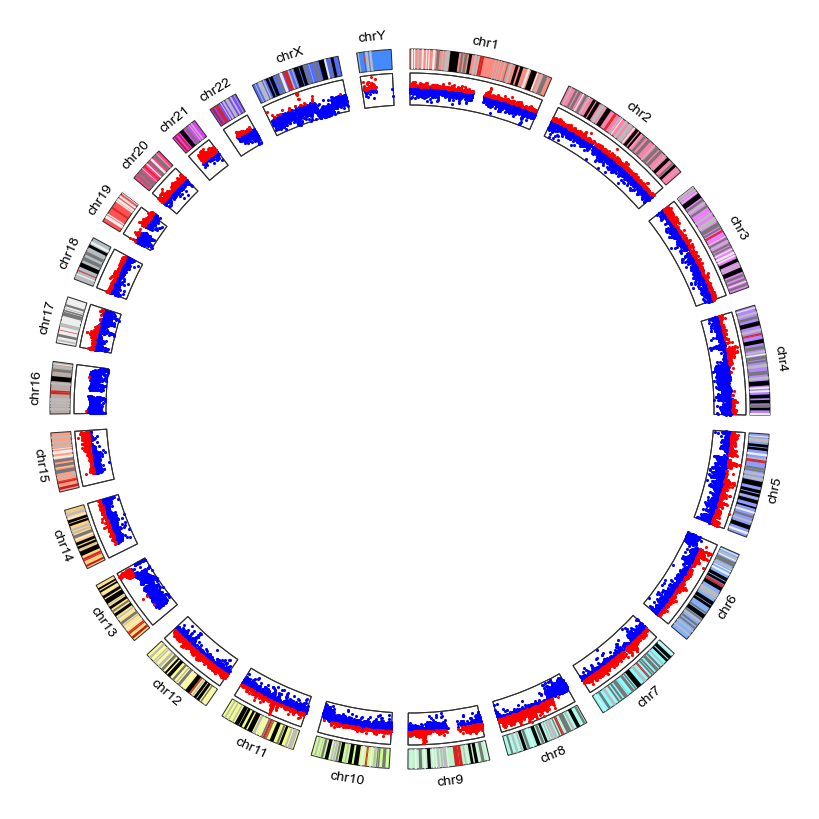

In [8]:
# pick the midpoint
midpoint = 0.15

# add these in two batches for each chromosome so that we can get the same color coding as in RCircos
# those with values < midpoint will be blue
# those with values > midpoint will be red
for name in names:
    usedf = dfCNV.get_group(name)
    
    lowdf = usedf.loc[usedf['Value'] < midpoint]
    circle.scatterplot(
        name, 
        data = lowdf['Value'].values,
        positions = ((lowdf['Start'] + lowdf['End'])/2.).values, #take the midpoint  
        rlim = [-1, 1], 
        raxis_range = (760, 840), 
        facecolor = "blue", 
        spine = True
    ) 

    highdf = usedf.loc[usedf['Value'] >= midpoint]
    circle.scatterplot(
        name, 
        data = highdf['Value'].values,
        positions = ((highdf['Start'] + highdf['End'])/2.).values, #take the midpoint  
        rlim = [-1, 1], 
        raxis_range = (760, 840), 
        facecolor = "red", 
        spine = True
    )
    
# show the figure
circle.figure

## 3. Create a scatter plot using the B-Allele data.

### 3.1. Read in the B-Allele data using  [```pandas```](https://pandas.pydata.org/).

In [9]:
# read in the B-allele frequency (BAF) data 
dfBAF = pd.read_csv('data/VCaP_B-allele-Frequency.tsv', sep = "\s+")

# randomly select 25000 lines (otherwise the plot is too full and takes too long to create)
dfBAF = dfBAF.sample(n = 25000)

# group the dataframe by the chromosome name so that it is easier to work with later
dfBAF = dfBAF.groupby('Chromosome')

dfBAF.get_group('chr1')

,Chromosome,Start,End,Value
24272,chr1,53417555,53417555,1.000000
43353,chr1,97717880,97717880,0.000000
61424,chr1,161982434,161982434,0.993564
66201,chr1,171418659,171418659,0.666561
196,chr1,976594,976594,1.000000
...,...,...,...,...
55186,chr1,149602696,149602696,0.000000
37117,chr1,83668484,83668484,0.661254
13835,chr1,29454524,29454524,0.999105
64196,chr1,167764444,167764444,0.998734


### 3.2 Add the B-Allele data to the circos figure as a scatter plot.

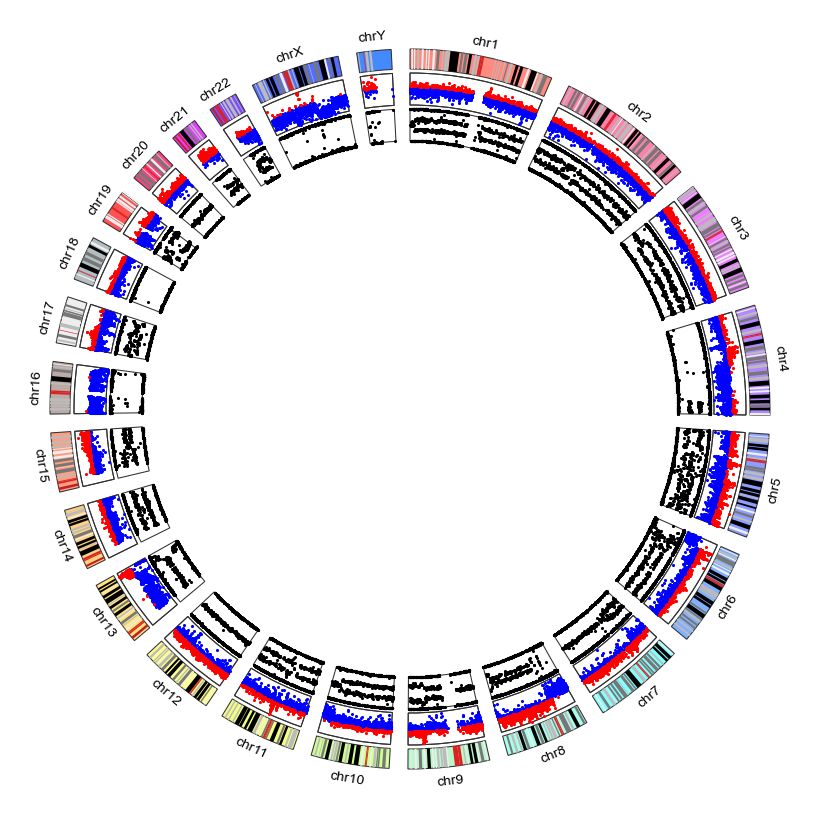

In [10]:
# These will all be black
for name in names:
    usedf = dfBAF.get_group(name)
    circle.scatterplot(
        name, 
        data = usedf['Value'].values,
        positions = ((usedf['Start'] + usedf['End'])/2.).values, #take the midpoint  
        rlim = [0, 1], 
        raxis_range = (670, 750), 
        facecolor = "black", 
        spine = True
    ) 

# show the figure
circle.figure

## 4. Create a link plot using the Junction data.

### 4.1 Read in the Junctions data using [```pandas```](https://pandas.pydata.org/).

In [11]:
# read in the junctions data and fix the column names
dfLinks = pd.read_table('data/VCaP-highConfidenceJunctions.tsv', skiprows = 11)

# select the necessary columns
dfLinks = dfLinks[dfLinks.columns[[1, 2, 5, 6]]]

# select only the links that go between different chromosomes
dfLinks = dfLinks.loc[dfLinks['LeftChr'] != dfLinks['RightChr']]

# select only the links that are within the names list
dfLinks = dfLinks.loc[(dfLinks['LeftChr'].isin(names)) & (dfLinks['RightChr'].isin(names))]

dfLinks.head()

,LeftChr,LeftPosition,RightChr,RightPosition
9,chr1,8706415,chr8,145491742
10,chr1,8706521,chr3,23338239
11,chr1,8707439,chr3,23338260
87,chr1,154452854,chr8,47059554
156,chr2,9841660,chr15,56972851


### 4.2 Add the Junctions data to the circos figure as a link plot.

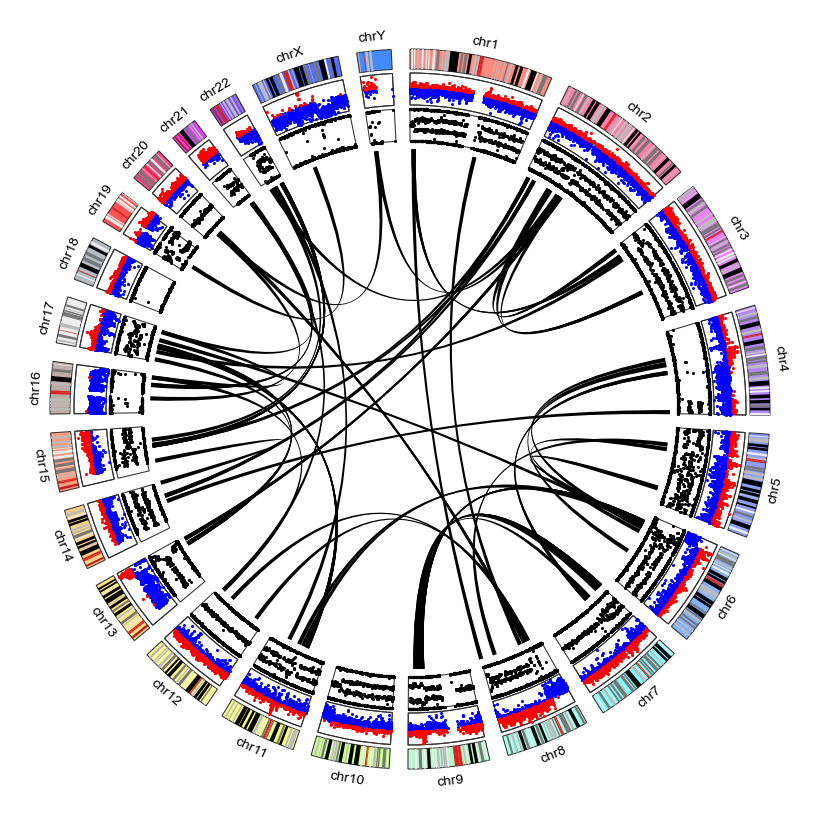

In [12]:
# I am simply defining a default line width that will be easy to see in the plot.
# this could instead be a variable if defined in the file.
linewidth = 1e7

# define the edge radius that the links will start from
edgeradius = 650

# create the links
for index, row in dfLinks.iterrows():
    circle.chord_plot(
        (row['LeftChr'], row['LeftPosition'] - linewidth/2., row['LeftPosition'] + linewidth/2., edgeradius),  # source
        (row['RightChr'], row['RightPosition'] - linewidth/2., row['RightPosition'] + linewidth/2., edgeradius), # destination
        facecolor = 'black'
    )
    
circle.figure

## 5. Save the final figure as a PDF.

In [13]:
circle.figure.savefig("cancer_circos.pdf")

meta NOT subset; don't know how to subset; dropped
